In [22]:
%cd ..
%cd root


/
/root


In [23]:
import pandas as pd
df = pd.read_csv("dwdata_1.csv")
df.head()

,Unnamed: 0,X,Y
0,0,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid
1,1,hes let us go,he needs to move his tardis into the circle of...
2,2,without special treatment it would have spread...,ah thats nice
3,3,when i came back with these satellite reports ...,nothings been moved
4,4,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...


Punctuation has already been removed, all words are lowered. I suppose stemming would not be a nice idea unless we preprocess the data whenever a user enters something. Let's build a simple model then!

In [24]:
import numpy as np
words_x = [""]
words_y = [""]
def word_to_list_x(x):
  words_x.append(str(x).split(" "))
def word_to_list_y(x):
  words_y.append(str(x).split(" "))
df.X.apply(word_to_list_x)
df.Y.apply(word_to_list_y)
words_x1 = [val for sublist in words_x for val in sublist]
words_y1 = [val for sublist in words_y for val in sublist]
words_x = set(words_x1)
words_y = set(words_y1)
print("X:")
print("   # of unique words: {}, Total Words: {}".format(len(words_x), len(words_x1)))
print("Y: ")
print("   # of unique words: {}, Total Words: {}".format(len(words_y), len(words_y1)))
print("Combined: ")
print("   # of unique words: {}, Total Words: {}".format(len(set(list(words_y)+list(words_x))), len(words_y1+words_x1)))
print("Total Training Size: {}".format(len(df)))

X:
   # of unique words: 30793, Total Words: 725045
Y: 
   # of unique words: 37657, Total Words: 939351
Combined: 
   # of unique words: 53382, Total Words: 1664396
Total Training Size: 76543


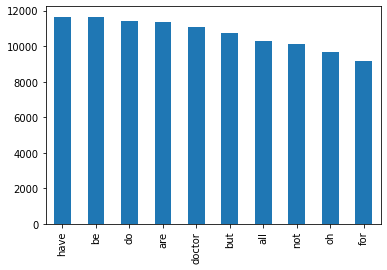

In [25]:
pd.Series(words_y1+words_x1).value_counts()[20:30].plot.bar()

Max words per sentence is 253 as per the last notebook


In [0]:
X = []
Y = []
def remove_num_X(x):
  x = str(x)
  result = ''.join([i for i in x if not i.isdigit()])
  X.append(result)
def remove_num_Y(x):
  x = str(x)
  result = ''.join([i for i in x if not i.isdigit()])
  Y.append(result)
df.X.apply(remove_num_X)
df.Y.apply(remove_num_Y)
df["X_1"] = X
df["Y_1"] = Y

In [36]:
word_freq = pd.Series(words_y1+words_x1).value_counts()
print("Total Number of Unique Words Before: {}".format(len(word_freq)))
ignored = word_freq[word_freq<=4]
word_freq = word_freq[word_freq>4]
print("Total Number of Unique Words After: {}".format(len(word_freq)))

Total Number of Unique Words Before: 53382
Total Number of Unique Words After: 11699


In [0]:
ignored = list(ignored)
X_1 = []
Y_1 = []
def filter_ignored_x(x):
  each_word = x.split(" ")
  result = " ".join([i for i in each_word if i not in ignored])
  X_1.append(result)
def filter_ignored_y(x):
  each_word = x.split(" ")
  result = " ".join([i for i in each_word if i not in ignored])
  Y_1.append(result)
df["X_1"].apply(filter_ignored_x)
df["Y_1"].apply(filter_ignored_y)
df["X_1"] = X_1
df["Y_1"] = Y_1

In [41]:
df.head()

,Unnamed: 0,X,Y,X_1,Y_1
0,0,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid
1,1,hes let us go,he needs to move his tardis into the circle of...,hes let us go,he needs to move his tardis into the circle of...
2,2,without special treatment it would have spread...,ah thats nice,without special treatment it would have spread...,ah thats nice
3,3,when i came back with these satellite reports ...,nothings been moved,when i came back with these satellite reports ...,nothings been moved
4,4,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...


In [0]:
import pandas as pd
df = pd.read_csv("")

In [0]:
maxlen = 255
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
all_xy = df["X_1"]
all_xy = all_xy.append(df["Y_1"])
TO = Tokenizer(num_words=20000)
TO.fit_on_texts(all_xy)
X_train = TO.texts_to_sequences(df["X_1"])
Y_train = TO.texts_to_sequences(df["Y_1"])
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = pad_sequences(Y_train, maxlen=maxlen)

In [45]:
print(X_train.shape)
print(Y_train.shape)

(76543, 255)
(76543, 255)


In [0]:
def glove_100d_dictionary(GLOVE_DIR):
  embeddings_index = {}
  f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  return embeddings_index
def embedding_matrix_creater(embedding_dimention):
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix
def embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix):
  
  embedding_layer = Embedding(input_dim = VOCAB_SIZE, 
                              output_dim = EMBEDDING_DIM,
                              input_length = MAX_LEN,
                              weights = [embedding_matrix],
                              trainable = False)
  return embedding_layer

embedding_layer = embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix)


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Input, Add, Dense, Flatten, Bidirectional, GlobalMaxPool1D, Dropout
#https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639
encoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
encoder_embedding = embed_layer(encoder_inputs)
encoder_LSTM = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

decoder_inputs = Input(shape=(maxlen, ), dtype='int32',)
decoder_embedding = embed_layer(decoder_inputs)
decoder_LSTM = LSTM(128, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

outputs = TimeDistributed(Dense(20000, activation='softmax'))(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs)
model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])